In [66]:
import numpy as np

#database handling
import pandas as pd

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#scientific calc
import astropy
from astropy.io.votable import parse
from astropy import units as u
from astropy.coordinates import SkyCoord

import scipy 
from scipy.optimize import minimize

import sympy

from RegscorePy import aic, bic

import emcee
import corner

## data import

In [87]:
profile='Zhao'

In [88]:
from astroquery.vizier import Vizier

VizOC_table2 = Vizier(catalog="J/A+A/659/A59/table2")
VizOC_table1 = Vizier(catalog="J/A+A/659/A59/table1")
VizOC_table2.ROW_LIMIT = -1

cluster = "Blanco_1"
OC_df = VizOC_table2.query_constraints(Cluster=cluster).values()[0].to_pandas()
OC_tb1_df = VizOC_table1.query_constraints(Cluster=cluster).values()[0].to_pandas()

## building density profile

Text(0, 0.5, 'pmdec')

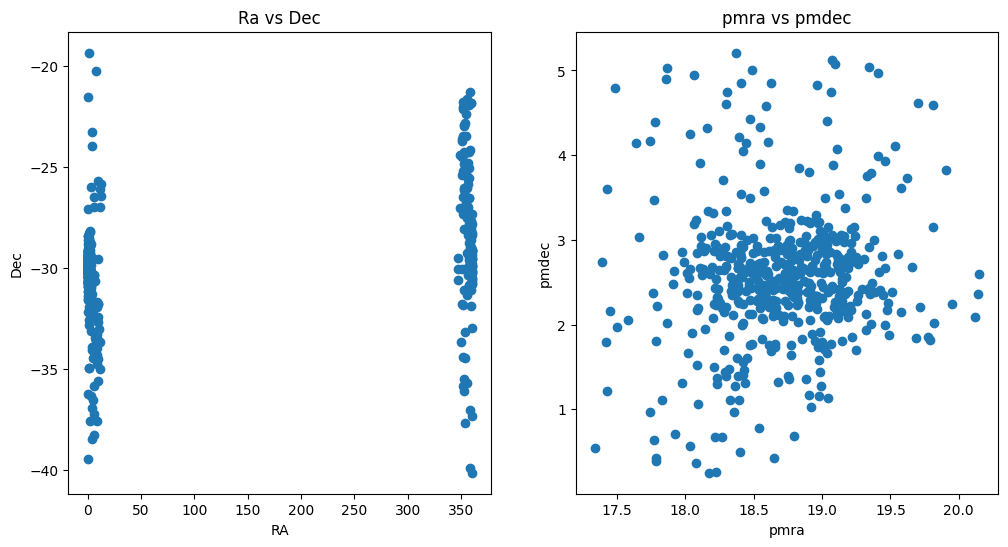

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(OC_df['RA_ICRS'], OC_df['DE_ICRS'], label='Blanco_1')
ax[1].scatter(OC_df['pmRA'], OC_df['pmDE'], label='Blanco_1')

ax[0].set_title('Ra vs Dec')
ax[1].set_title('pmra vs pmdec')

ax[0].set_xlabel('RA')
ax[0].set_ylabel('Dec')

ax[1].set_xlabel('pmra')
ax[1].set_ylabel('pmdec')

In [90]:
#getting and converting cluster members' eq coords to cartesian
blanco_1_eq_coords = SkyCoord(ra=OC_df['RA_ICRS'] * u.degree,
                              dec=OC_df['DE_ICRS'] * u.degree, 
                              distance=(1000 / OC_df['plx']) * u.Parcsec, frame='icrs')
blanco_1_cart_coords = blanco_1_eq_coords.cartesian.x, blanco_1_eq_coords.cartesian.y, blanco_1_eq_coords.cartesian.z


#getting and converting the center coords 
blanco_1_eq_center_coords = SkyCoord(ra=OC_tb1_df['RA_ICRS'] * u.degree, 
                                     dec=OC_tb1_df['DE_ICRS'] * u.degree, 
                                     distance=(1000/OC_tb1_df['plx']) * u.Parcsec, frame='icrs')
blanco_1_cart_center_coords = blanco_1_eq_center_coords.cartesian.x, blanco_1_eq_center_coords.cartesian.y, blanco_1_eq_center_coords.cartesian.z

#getting the distance of stars from the center of clusters
def calc_dist(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

d = calc_dist(blanco_1_cart_center_coords[0], blanco_1_cart_center_coords[1],
         blanco_1_cart_coords[0], blanco_1_cart_coords[1])

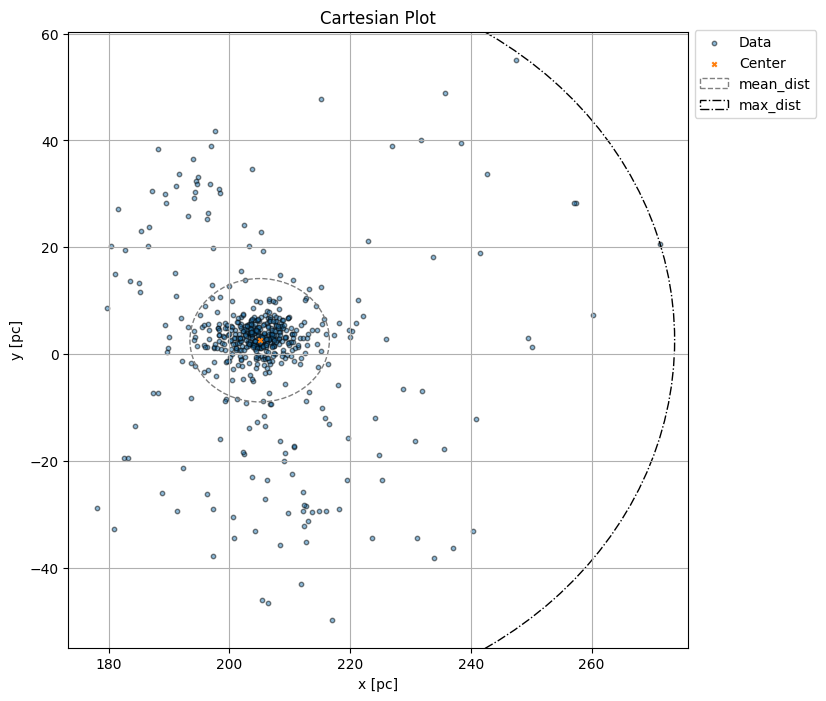

In [91]:
#plotting the cluster with radius regions
plt.figure(figsize=(8, 8))
plt.scatter(blanco_1_cart_coords[0], blanco_1_cart_coords[1], label='Data', s=10, alpha=0.5, edgecolors='k')
plt.scatter(blanco_1_cart_center_coords[0], blanco_1_cart_center_coords[1], label='Center', marker='x', s=10)

ax = plt.gca()
c_max = plt.Circle((blanco_1_cart_center_coords[0].value,blanco_1_cart_center_coords[1].value), radius=np.max(d.value),
                    edgecolor='k',linestyle='-.', fill=False, label='max_dist')
c_mean = plt.Circle((blanco_1_cart_center_coords[0].value,blanco_1_cart_center_coords[1].value), radius=np.mean(d.value),
                    edgecolor='gray', linestyle='--', fill=False, label='mean_dist')
ax.add_artist(c_mean)
ax.add_artist(c_max)


plt.xlabel('x [pc]')
plt.ylabel('y [pc]')
plt.title('Cartesian Plot')
plt.legend(loc=[1.01, 0.86])
plt.grid()

Text(0.5, 0, 'z [pc]')

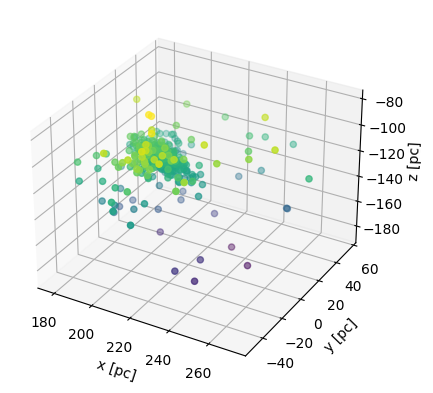

In [92]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(blanco_1_cart_coords[0], blanco_1_cart_coords[1], blanco_1_cart_coords[2], 
c=blanco_1_cart_coords[2], cmap='viridis')
ax.scatter3D(blanco_1_cart_center_coords[0], blanco_1_cart_center_coords[1], blanco_1_cart_center_coords[2])

ax.set_xlabel('x [pc]')
ax.set_ylabel('y [pc]')
ax.set_zlabel('z [pc]')

## fit different functions

In [93]:
#the profile functions

def King_profile(r, rho_0, r_c, r_t):
    rho_k = rho_0 * (((1 + (r / r_c) ** 2) ** -0.5 - (1 + (r_t / r_c) ** 2) ** -0.5) ** 2)
    mask = r > r_t
    rho_k[mask] = 0
    return rho_k

def Plummer_profile(r, rho_0, a):
    rho_P = rho_0 * ((1 + (r * r / a / a)) ** -2.5)
    return rho_P

def Zhao_profile(r, rho_0, a, gamma):
    rho = rho_0 * ((r / a) ** -gamma) * ((1 + (r / a) ** 2) ** ((gamma - 4.5) / 2))
    return rho

## CDF

In [94]:
CDF_x = np.sort(d.value)
x_axis = np.linspace(3e-2, CDF_x.max(), 1001)
CDF = np.arange(1, len(d) + 1) / len(d)  #normalised CDF

## error in CDF calculation (MC error propagation)

In [95]:
d_d = lambda plx, eplx: (1000) * ((1 / plx) ** 2. * (eplx))
np.random.seed(None)
#distance to stars in pc 
dist = 1000 / OC_df['plx']
#distance errors
dist_err = d_d(OC_df['plx'], OC_df['e_plx'])

#number of realisations of the CDF
N = 100

CDF_many = np.zeros((len(OC_df['RA_ICRS']), N))
CDF_x_many = np.zeros((len(OC_df['RA_ICRS']), N))


#Setting defaults for centre at function definition
def make_a_CDF(ra, dec, distance, era, edec, edist, centra, centdec,
               centdist, ecentdist):
    dist_draw = []
    ra_draw   = []
    dec_draw  = []
    #Uncomment code to include error in cluster centre
    #centra_draw = [] 
    #centdec_draw = []
    
    centdist_draw = []
    for i in range(len(ra)):
        dist_draw.append(np.random.normal(distance[i], edist[i], size=1)[0])
        ra_draw.append(np.random.normal(ra[i], era[i], size=1)[0])
        dec_draw.append(np.random.normal(dec[i], edec[i], size=1)[0])

        #Uncomment to include error in cluster
        #centra_draw.append(np.random.normal(centra, ecentra, size=1)[0])
        #centdec_draw.append(np.random.normal(centdec, ecentdec, size=1)[0])
        #centdist_draw.append(np.random.normal(centdist, ecentdist, size=1)[0])


    try1= SkyCoord(ra=ra_draw * u.degree, dec=dec_draw * u.degree, distance=dist_draw * u.Parcsec, frame='icrs')
    try1 = try1.cartesian.x, try1.cartesian.y, try1.cartesian.z
    tryc1= SkyCoord(ra=centra * u.degree, dec=centdec * u.degree, distance=centdist * u.Parcsec, frame='icrs')
    tryc1 = tryc1.cartesian.x, tryc1.cartesian.y, tryc1.cartesian.z



    dtry1 = calc_dist(tryc1[0], tryc1[1], try1[0], try1[1])

    CDF_x_try1 = np.sort(dtry1.value)
    CDFtry1 = np.arange(1, len(dtry1) + 1) / len(dtry1)  #normalised CDF
    
    return CDF_x_try1, CDFtry1


CDF_err = []

#Loop over the number of realisations we want to create
for i in range(N):
    CDF_x_many[:, i], CDF_many[:, i] = make_a_CDF(OC_df['RA_ICRS'], OC_df['DE_ICRS'], dist, 
                                        OC_df['e_RA_ICRS'], OC_df['e_DE_ICRS'], dist_err,
                                        OC_tb1_df['RA_ICRS'], OC_tb1_df['DE_ICRS'],
                                        1000 / OC_tb1_df['plx'], d_d(OC_tb1_df['plx'], OC_tb1_df['s_plx']))
    
#Uncomment to plot realisations.
#     plt.plot(CDF_x_many[:,i], CDF_many[:,i], alpha=0.05, c="red")
    
# for each data point compute the standard devation of all the realisations at that value of x
for k in range(N):
        
    CDF_interp_func = scipy.interpolate.interp1d(CDF_x_many[:,k], CDF_many[:,k], fill_value="extrapolate")
    CDF_err.append(CDF_interp_func(x_axis))
            
actual_errors = np.std(np.array(CDF_err), axis=0)


## Symbolic CDF

$$
\log{likelihood} = -0.5 * \left( \frac{(expected - observed)^2}{\sigma^2} + \log{\sigma^2} \right)
$$

In [96]:
def pdf2cdf(r, profile='King', *args):
    
    if profile=='King':
    #getting the cdf from the pdf
        pdf = King_profile(r, *args)                 #defining the pdf
        
    elif profile=='Plummer':
        pdf = Plummer_profile(r, *args)                 

    elif profile=='Zhao':
        pdf = Zhao_profile(r, *args)             
       
    else:
        print('Please choose a profile between King, Plummer or Zhao')
    
    return np.cumsum(pdf) / (np.cumsum(pdf).max()+1e-8)

def log_likelihood(theta,x,y,y_err,profile):
    model = pdf2cdf(x, profile, *theta)
    sigma2 = y_err ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2)) #neg. chi-sq. + nuisance param

profiles_dict = {
    'King':['rho_0', 'r_c', 'r_t'],
    'Plummer': ['rho_0', 'a'],
    'Zhao':['rho_0', 'a', 'gamma'],
}

def mle(init_guess,x,y,y_err,profile='King',print_solution=False):
    if profile == 'King':
        bounds = np.array([[0, 0, 10], [1, 10, np.inf]]).T
    elif profile == 'Plummer':
        bounds = np.array([[0, 0], [np.inf, np.inf]]).T
    elif profile == 'Zhao':
        bounds = np.array([[0, 0, 0], [np.inf, np.inf, np.inf]]).T
                         
    #getting the args for minimise function
    nll = lambda *args: -log_likelihood(*args)
    
    #finding solution by minimise alogorithm
    soln = minimize(nll, init_guess, bounds=bounds
                    , args=(x, y, y_err, profile)) #args = (x,y,yerr,cdf_function)

    if print_solution==True:
        
        print('-' * 30)
        print('Message: ',soln.message)
        print('nhev: ',soln.nfev)
        print('nit: ',soln.nit)
        print('njev: ',soln.njev)
        print('status: ',soln.status)
        print('success: ',soln.success)
        print('-' * 30)

        print("Maximum likelihood estimates:")  

        for i in range(0, len(profiles_dict[profile])):
            print(f"{profiles_dict[profile][i]} = {soln.x[i]:.3f}")

        print('-' * 30)

    else: 
        pass

    return soln

------------------------------
Message:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
nhev:  104
nit:  18
njev:  26
status:  0
success:  True
------------------------------
Maximum likelihood estimates:
rho_0 = 0.006
a = 37.015
gamma = 0.455
------------------------------


Text(0, 0.5, 'y')

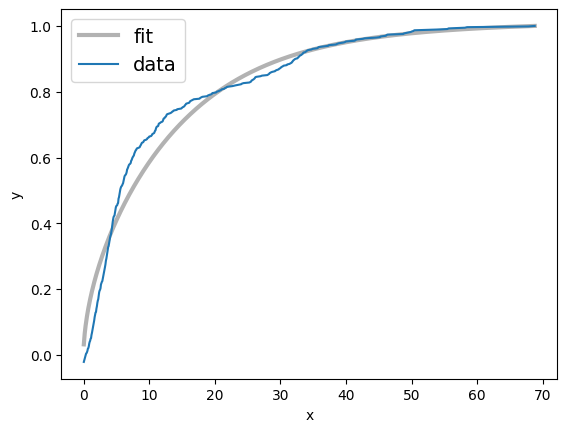

In [97]:
#err array 
np.random.seed(42)
yerr  = np.array(actual_errors) #np.random.normal(size=len(CDF)) / 1e10

if profile == 'King':
    init = np.array([0.01, np.mean(d.value), 5 * np.mean(d.value)]) #rho_0, r_c, r_t
elif profile == 'Plummer':
    init = np.array([0.01, np.mean(d.value)]) #rho_0, r_c, r_t
elif profile == 'Zhao':
    init = np.array([0.01, np.mean(d.value), 2]) #rho_0, r_c, r_t
    
CDF_interp_func = scipy.interpolate.interp1d(CDF_x,CDF, fill_value="extrapolate")

#finding solution by minimise alogorithm
soln = mle(init_guess=init,
            x=x_axis,
            y=CDF_interp_func(x_axis),
            y_err = yerr,
            profile=profile,
            print_solution=True)

plt.plot(x_axis, pdf2cdf(x_axis, profile, *soln.x), "k", alpha=0.3, lw=3, label="fit")
plt.plot(x_axis, CDF_interp_func(x_axis), label='data')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y")

## compare models

In [98]:
aic.aic(CDF_interp_func(x_axis), pdf2cdf(x_axis, profile, *soln.x), len(init))

-6509.040849039364

# MCMC

In [99]:
def log_likelihood(theta,x,y,y_err,profile='King'):
    # rho0, a, alpha, beta, gamma = theta
    # model     = f_zhao(x, rho0, a, alpha, beta, gamma) * dx       
    # log_lh   = np.sum((model - y) ** 2 / model)

    model = pdf2cdf(x, profile, *theta)
    sigma2 = y_err ** 2
    log_lh =  -0.5 * np.sum((y - model) ** 2 / sigma2) #neg. chi-sq. + nuisance param

    
    if np.isnan(log_lh):
        return -np.inf
        
    if (log_lh > 0.531 * (len(x)-len(theta))):
        return -1e3 * log_lh
    
    return float(-log_lh)

def log_prior(theta, mean_theta, std_theta, weight):
    lh_prior = 0
    if theta[0] <0:
        return np.inf
    bias = (theta - mean_theta) ** 2 / std_theta ** 2
    if (bias > 5.01).any():
        return -np.inf
    bias *= weight
    return - bias.sum()

def log_probability(theta, mean_theta, std_theta, x, y, weight_pr=1e-5, weight_lh=1e-2, prof='King'):
    lp = log_prior(theta, mean_theta, std_theta, weight_pr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, weight_lh, prof)

In [100]:
soln.x

array([5.55983943e-03, 3.70151869e+01, 4.54551761e-01])

In [102]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

x=x_axis
y=CDF_interp_func(x_axis)
weight_lh = yerr

theta = init

mean_theta = soln.x

std = []
dist_sig = [0.2,15,0.1]
for i in range(0,len(profiles_dict[profile])):
    dist = np.random.normal(soln.x[i],dist_sig[i],1000)
    std.append(np.std(dist))

std_theta = np.array(std)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(mean_theta, std_theta, x, y,1e-5,weight_lh,profile)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:12<00:00, 788.88it/s]


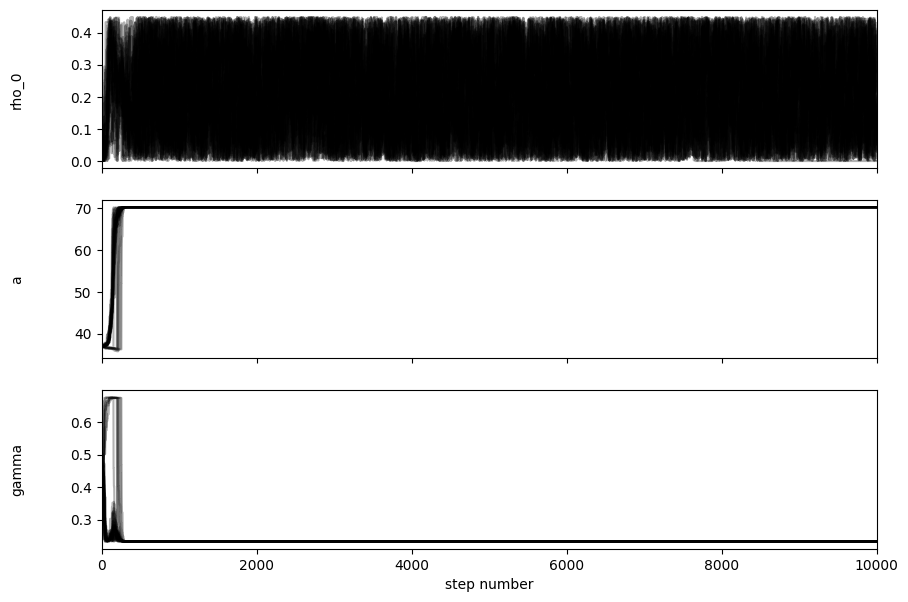

In [103]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = profiles_dict[profile]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [104]:
tau = sampler.get_autocorr_time()
print(tau)

[ 70.16651845 179.06909496 112.15383971]


In [105]:
flat_samples = sampler.get_chain(discard=2000, thin=30, flat=True)
print(flat_samples.shape)

(8512, 3)


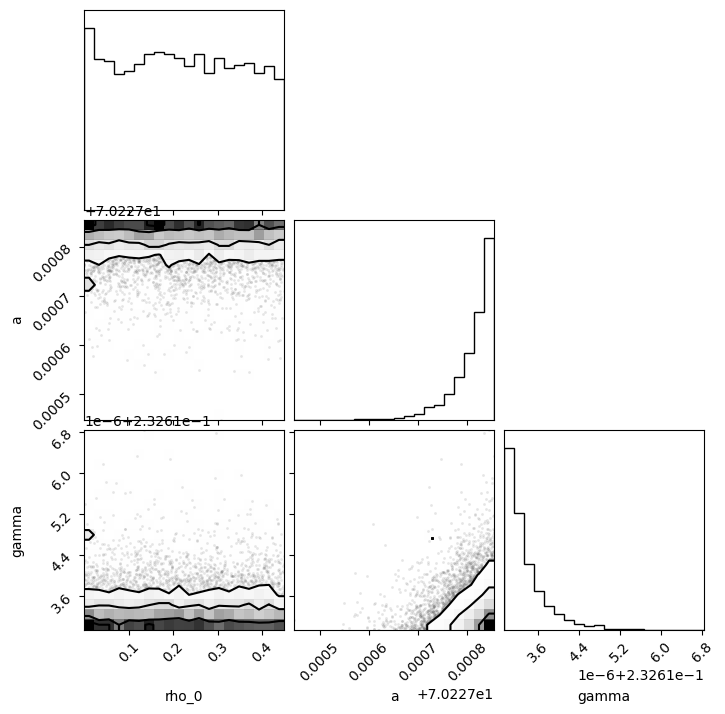

In [107]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, 
    # truths=[m_true, b_true, np.log(f_true)]
);

## HOORAY!!!